In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
#pip install pytorch-tabnet
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#from pytorch_tabnet.tab_model import TabNetClassifier
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import torch
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
%matplotlib inline
from imblearn.over_sampling import SMOTE
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import warnings
warnings.filterwarnings("ignore")
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/robi-datathon-2-pre-assessment/sample_submission.csv
/kaggle/input/robi-datathon-2-pre-assessment/train.csv
/kaggle/input/robi-datathon-2-pre-assessment/test.csv


In [2]:
train=pd.read_csv("../input/robi-datathon-2-pre-assessment/train.csv")
columns=train.drop(['id',], axis=1).columns

#  Upsampling to solve data imbalance

In [3]:

cat_col=[col for col in train.columns if train[col].dtype=='object']
num_col=[col for col in train.columns if train[col].dtype!='object']
    
le = LabelEncoder()
train=train.fillna(0)
for col in cat_col:
    train[col] = le.fit_transform(train[col].astype(str))
# Resample the minority class. You can change the strategy to 'auto' if you are not sure.
sm = SMOTE(sampling_strategy='minority', random_state=7)

# Fit the model to generate the data.
oversampled_trainX, oversampled_trainY = sm.fit_resample(train.drop(['id','label'], axis=1), train['label'])
oversampled_train = pd.concat([pd.DataFrame(oversampled_trainX),pd.DataFrame(oversampled_trainY) ], axis=1)
oversampled_train.columns = columns

In [4]:
oversampled_train['label'].value_counts()

0    23562
1    23562
Name: label, dtype: int64

In [5]:
cat_col=[col for col in train.columns if train[col].dtype=='object']
num_col=[col for col in train.columns if train[col].dtype!='object']
    

# Preprocess Function

**Some features have null values only so they have been removed**

In [6]:
def preprocess(train,istest):
    cat_col=[col for col in train.columns if train[col].dtype=='object']
    num_col=[col for col in train.columns if train[col].dtype!='object']
    
    le = LabelEncoder()
    train=train.fillna(0)
    for col in cat_col:
        train[col] = le.fit_transform(train[col].astype(str))
#     for c in cat_col:
#         train[c] = train[c].astype('category')
    if istest==0:
        #X=train.drop(['id','label','s54','s55','s56','s57','s59','s58','s53','s12','n11','n12','n13','n14','n15'],axis=1)
        #X=train[['gender','s52','s16','n6','n5','s70','s71','s69','s18','s48','s17','s11']]
        #X=train.drop(['s54','s55','s56','s57','s59','label'],axis=1)
        X=train.drop(['label'],axis=1)
        #X=train[['s69','s52','s16']]
        
        
        Y=train['label']
       
        return X,Y
    else:
#         X=train.drop(['id','s54','s55','s56','s57','s59'],axis=1)
#         X=train[['s69','s52','s16']]
#         X=train.drop(['id','s54','s55','s56','s57','s59'],axis=1)
        X=train.drop(['id'],axis=1)
       
        return X
        
    

In [7]:
X,Y=preprocess(oversampled_train,0)

In [8]:
X.head()

,gender,s11,s12,s13,s16,s17,s18,s48,s52,s53,...,n6,n7,n8,n9,n10,n11,n12,n13,n14,n15
0,1,1,0,1,3,3,1,0,1,1,...,0.017176,-9.126056,1.732291,3.698504,4.804517,1.544484,0,0,0.631220,5
1,1,1,1,1,3,3,1,1,1,1,...,0.013857,-9.098287,1.505885,6.791357,6.110416,1.712354,0,0,0.392746,3
2,1,1,1,1,3,3,1,0,1,1,...,0.013943,-9.234894,1.503828,4.109685,3.953226,1.804260,0,0,0.222537,2
3,0,1,1,1,3,3,1,0,1,1,...,0.010387,-9.378025,1.485863,7.265876,4.559419,1.537645,0,0,0.154409,4
4,1,0,1,1,1,3,3,1,2,1,...,0.016289,-9.261962,1.619210,3.737647,4.052003,1.637831,0,1,0.737560,1


# Feature analysis for feature selection

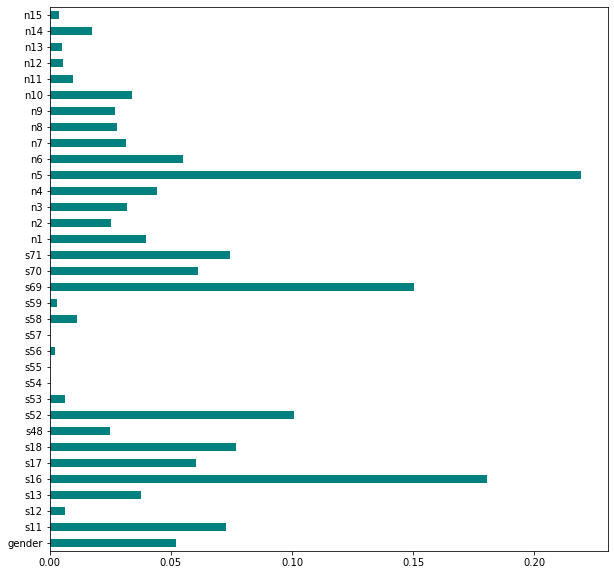

In [9]:
## Feature importance is analysed here
plt.figure(figsize=(10,10))
importances=mutual_info_classif(X,Y)
feat_imp=pd.Series(importances,X.columns)
feat_imp.plot(kind='barh',color='teal')
plt.show()


In [10]:
# def train(model1,model2,model3,model4,cv_splits):
#     fold=0
#     total_roc=[]
#     skf = StratifiedKFold(n_splits=cv_splits)
#     for train_index, test_index in skf.split(X, Y):
#         x_train, x_val = X.iloc[train_index], X.iloc[test_index]
#         y_train, y_val = Y.iloc[train_index], Y.iloc[test_index]
        
#         thr=0.5
#         model1.fit(x_train,y_train)
#         preds1=model1.predict_proba(x_val)
#         final_preds1=[1 if i[1]>thr else 0 for i in preds1]
# #         model2.fit(x_train,y_train)
# #         preds2=model2.predict_proba(x_val)
# #         final_preds2=[1 if i[1]> thr else 0 for i in preds2]
# #         model3.fit(x_train,y_train)
# #         preds3=model3.predict_proba(x_val)
# #         final_preds3=[1 if i[1]>thr else 0 for i in preds3]
# #         model4.fit(x_train,y_train)
# #         preds4=model4.predict_proba(x_val)
# #         final_preds4=[1 if i[1]>thr else 0 for i in preds4]
                

#         ######################################
#         ######################################
       
#         final_preds=np.array(final_preds1)
# #         +np.array(final_preds2)+np.array(final_preds3)+np.array(final_preds4)
# #         print(len(final_preds1),len(final_preds))
# #         final_preds=[1 if i >1 else 0 for i in final_preds]
# #         print(final_preds)
       
# #        preds=model.predict_proba(x_val)
# #        final_preds2=[1 if i[1]>0.15 else 0 for i in preds]
#        # final_preds=np.argmax(final_preds,axis=1)
      
#         print(f"Fold--{fold}")
#         fold+=1
#         roc=roc_auc_score(y_val,final_preds)
#         total_roc.append(roc)
#         print(roc)
#         print("-----------------------------------------")
#     print(f"Average Roc---{sum(total_roc)/len(total_roc)}")

# Train Function

In [11]:
# 5 fold cross-validation training and roc printed on validation data
def train(model,cv_splits):
    fold=0
    total_roc=[]
    skf = StratifiedKFold(n_splits=cv_splits)
    for train_index, test_index in skf.split(X, Y):
        x_train, x_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = Y.iloc[train_index], Y.iloc[test_index]
        
        model.fit(x_train,y_train)
        preds=model.predict(x_val)
        final_preds=preds

        ######################################
        ######################################
       
        final_preds=np.array(final_preds)
        print(f"Fold--{fold}")
        fold+=1
        roc=roc_auc_score(y_val,final_preds)
        total_roc.append(roc)
        print(roc)
        print("-----------------------------------------")
    print(f"Average Roc---{sum(total_roc)/len(total_roc)}")

In [12]:


#XGBmodel
# model1= xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1)
# # LightGBM
# model2 = lgb.LGBMClassifier(n_estimators=100,learning_rate=0.1,objective='binary',boosting_type='gbdt',max_depth=6,metric='binary_logloss')
#RandomForest
model3=RandomForestClassifier(n_estimators=250)

# training starts
train(model3,5)

Fold--0
0.8394615802766396
-----------------------------------------
Fold--1
0.9142726499365803
-----------------------------------------
Fold--2
0.9169213085793476
-----------------------------------------
Fold--3
0.913101454741554
-----------------------------------------
Fold--4
0.91723259762309
-----------------------------------------
Average Roc---0.9001979182314421


# Submission

In [13]:
submission=pd.read_csv("../input/robi-datathon-2-pre-assessment/test.csv")
test=pd.read_csv("../input/robi-datathon-2-pre-assessment/test.csv")

X=preprocess(test,1)
X.shape
final_preds=model3.predict(X)
submission=submission[['id']]


submission['label']=final_preds

submission.to_csv('Code_Nullhypothesis_ 1m58vg.csv',index=False)
submission.head()

,id,label
0,b'gAAAAABinOi328DZcweGB4_nOyHA3Dy6o1YKYKyf3COx...,1
1,b'gAAAAABinOikutEIBjkUXl9lYTg4RI6jc4NfiMUCcVsn...,1
2,b'gAAAAABinOjBM70jBXOroAlUSq5lNXMd_oP0PU7jLQE5...,1
3,b'gAAAAABinOimitAnqlgOcqnD_LeNL3WEbXNGvjd3QVPi...,0
4,b'gAAAAABinOi3W9p3Oka5MV_dc2TeorZUcIWOnnODSx7E...,0
